## <font color='darkblue'>Section3: Bootstrap Estimations and Bagging</font>
This course is from Udemy <b>["Ensemble Machine Learning in Python"](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/)</b>. This section is coming from [here](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6240244#overview).
* Bootstrap Estimation
* Bootstrap Demo
* Bagging
* Bagging Regression Tree
* Bagging Classification Trees
* Stacking

## <font color='darkBlue'>Bootstrap Estimation</font>
* I hinted earlier that combining several models could help us get lower bias and lower variance at the same time
* Key tool we need first: <b>[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))</b>
* aka. resampling
* Fascinating result:
    * Same data
    * Calculate the same thing several times
    * Better results!
* But first, let's look at bootstrap for simple parameter estimates like mean
> Given: X = {$x_{1}$,$x_{2}$,...,$x_{N}$} <br/>
> for b=1..B: <br/>
>     $X_{b}$ = sample_with_replacement(X) # size of $X_{b}$ is N <br/>
>     sample_mean[b] = sum($X_{b}$)/N <br/>
> Calculate mean and variance of {sample_mean[1], ..., sample_mean[B]} <br/>
> Why? Big variance -> not confident about value of mean <br/>

### <font color='darkgreen'>Sampling with replacement</font>
> Given X = {1,2,3,4,5} <br/>
> I sample from this and I get 5 <br/>
> I sample again and I can get 5 again. <br/>
> In fact, it's possible to get {5,5,5,5,5} <br/>
> If I sampled without replacement, the only possible result is the original dataset (not considering order) <br/>

## <font color='darkblue'>Bootstrap Demo</font>
This part will show the parameters of bootstrap and code is from [`bootstrap.py`](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/supervised_class2/bootstrap.py)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

B = 200
N = 20
X = np.random.randn(N)

print("sample mean of X:", X.mean())

sample mean of X: -0.059513831498785585


Now let's do the bootstrap:

In [2]:
individual_estimates = np.empty(B)
for b in range(B):
    sample = np.random.choice(X, size=N)
    individual_estimates[b] = sample.mean()

Now let's check the parameters of bootstrap result:

bootstrap mean of X: -0.049133646525427704


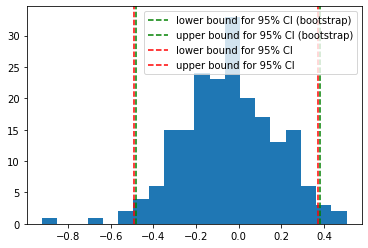

In [3]:
bmean = individual_estimates.mean()
bstd = individual_estimates.std()
lower = bmean + norm.ppf(0.025)*bstd # norm.ppf(0.025) == -1.96
upper = bmean + norm.ppf(0.975)*bstd # norm.ppf(0.975) == +1.96

# traditional way of calculating CI
lower2 = X.mean() + norm.ppf(0.025)*X.std()/np.sqrt(N)
upper2 = X.mean() + norm.ppf(0.975)*X.std()/np.sqrt(N)

print("bootstrap mean of X:", bmean)

plt.hist(individual_estimates, bins=20)
plt.axvline(x=lower, linestyle='--', color='g', label="lower bound for 95% CI (bootstrap)")
plt.axvline(x=upper, linestyle='--', color='g', label="upper bound for 95% CI (bootstrap)")
plt.axvline(x=lower2, linestyle='--', color='r', label="lower bound for 95% CI")
plt.axvline(x=upper2, linestyle='--', color='r', label="upper bound for 95% CI")
plt.legend()
plt.show()

## <font color='darkblue'>Bagging</font>
([link](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6240248#overview))
* Bagging = bootstrap aggregating = application of bootstrap to ML models.
* Looks exactly like bootstrapping except instead of calculating a "theta_hat", we train a model instead.

### <font color='darkgreen'>Training</font>
Pseudo code as below:
```python
models = []
for b = 1..B:
    model = Model()
    Xb, Yb = resample(X)
    model.fit(Xb, Yb)
    models.append(model)
```

### <font color='darkgreen'>Prediction</font>
Average if regression, vote if classification. Pseudo code for regression:
```python
def predict(X):
    return np.mean([model.predict(X) for model in models], axis=1)
```
Classification is harder b/c we need to collect the votes. If classifier returns class probabilities, we can just use avaraging.

### <font color='darkgreen'>Classification (Naive)</font>
```python
def predict_one(x):
    votes = {}
    for model in models:
        k = model.predict(x)
        votes[k]++
        
    argmax = 0, max = -inf # doesn't sort, that's O(NlogN)
    for k, v in votes.iteritems():
        if v > max:
            argmax = k; max = v
            
    return argmax
```
Then we can predict multiple instance by pseudo code below:
```python
def predict(X):
    # `N` as number of instance in `X`
    # `K` as number of class
    output = np.zeros((N,K))
    for model in models:
        output[np.arange(N), model.predict(X)] + 1
    return output.argmax(axis=1)
```
### <font color='darkgreen'>Classification (Binary)</font>
```python
def predict(X):
    # `N` as number of instance in `X`
    # `B` as number of model in `models`
    output = np.zeros(N)
    for model in models:
        output += models.predict(X)
    return np.round(output/B)
```

## <font color='darkblue'>Bagging Regression Tree</font>
([link](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6240250#questions))
In this segment, we are going to explore bagging regression. The code below is from [`bagging_regression.py`](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/supervised_class2/bagging_regression.py).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle


# create the data
T = 100
x_axis = np.linspace(0, 2*np.pi, T)
y_axis = np.sin(x_axis)

# get the training data
N = 30
idx = np.random.choice(T, size=N, replace=False)
Xtrain = x_axis[idx].reshape(N, 1)
Ytrain = y_axis[idx]

Let's try the <b>[DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)</b>

score for 1 tree: 0.9902539285114842


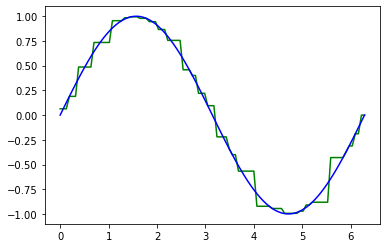

In [18]:
model = DecisionTreeRegressor()
model.fit(Xtrain, Ytrain)
dtr_prediction = model.predict(x_axis.reshape(T, 1))
print("score for 1 tree:", model.score(x_axis.reshape(T, 1), y_axis))

# plot the lone decision tree's predictions
plt.plot(x_axis, dtr_prediction, color='g')
plt.plot(x_axis, y_axis, color='b')
plt.show()

Now let's define bagging decision tree <b><font color='blue'>BaggedTreeRegressor</font></b>

In [10]:
class BaggedTreeRegressor:
    def __init__(self, B):
        '''
        @param B(int):
            Sampling time
        '''
        self.B = B

    def fit(self, X, Y):
        N = len(X)
        self.models = []
        for b in range(self.B):
            idx = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]

            model = DecisionTreeRegressor()
            model.fit(Xb, Yb)
            self.models.append(model)

    def predict(self, X):
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X)
            
        return predictions / self.B

    def score(self, X, Y):
        d1 = Y - self.predict(X)
        d2 = Y - Y.mean()
        return 1 - d1.dot(d1) / d2.dot(d2)

Let's train the bagging decision tree and see how it performs:

score for bagged tree: 0.9939021273488241


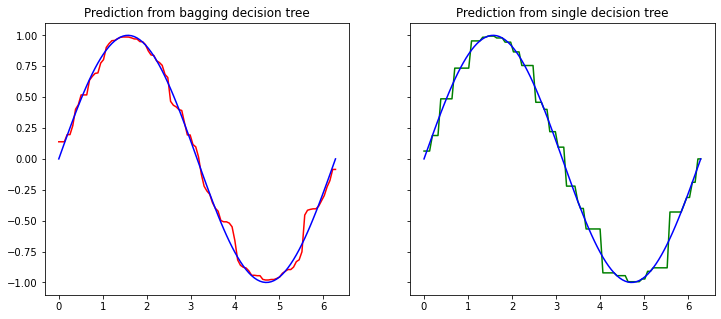

In [22]:
plt.rcParams["figure.figsize"] = (12,5)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

model = BaggedTreeRegressor(200)
model.fit(Xtrain, Ytrain)
print("score for bagged tree:", model.score(x_axis.reshape(T, 1), y_axis))
bd_prediction = model.predict(x_axis.reshape(T, 1))

# plot the bagged regressor's predictions
ax = axs[0]
ax.plot(x_axis, bd_prediction, color='r')
ax.plot(x_axis, y_axis, color='b')
ax.set_title('Prediction from bagging decision tree')

ax = axs[1]
ax.plot(x_axis, dtr_prediction, color='g')
ax.plot(x_axis, y_axis, color='b')
ax.set_title('Prediction from single decision tree')

plt.show()

We can observe that the output (red line) from bagging decision tree is smoother than the output (green line) from single decision tree.

## <font color='darkblue'>Bagging Classification Trees</font>
([link](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6240252#questions))
In this segment, we are going to explore bagging usage in classification. The code below is from [`bagging_classification.py`](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/supervised_class2/bagging_classification.py)

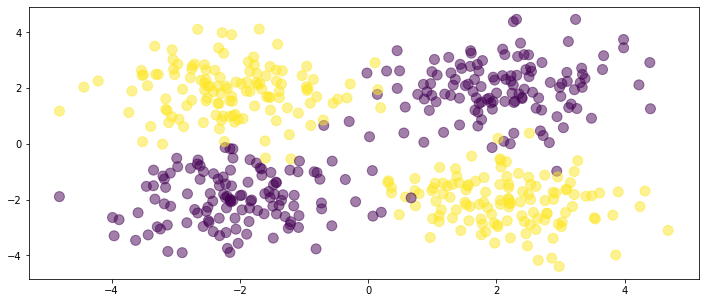

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from util import plot_decision_boundary

np.random.seed(10)

# create the data
N = 500
D = 2
X = np.random.randn(N, D)

# noisy XOR
sep = 2
X[:125] += np.array([sep, sep])
X[125:250] += np.array([sep, -sep])
X[250:375] += np.array([-sep, -sep])
X[375:] += np.array([-sep, sep])
Y = np.array([0]*125 + [1]*125 + [0]*125 + [1]*125)

# plot the data
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plt.show()

Now let's see how the result of single decision tree look like:

score for 1 dt: 1.0


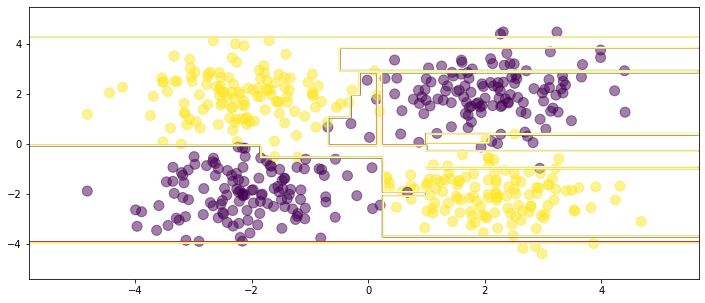

In [36]:
model = DecisionTreeClassifier()
model.fit(X, Y)
print("score for 1 dt:", model.score(X, Y))

# plot data with boundary
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(plt, X, model)
plt.show()

Then we define <b><font color='blue'>BaggedTreeClassifier</font></b> to train bagged decision tree classifier:

In [37]:
class BaggedTreeClassifier:
    def __init__(self, B, max_depth=2):
        r'''
        @param B:
            Number of sampling in building bagged dt classifier
        @param max_depth:
            Hyperparameter `max_depth` of DecisionTreeClassifier
        '''
        self.B = B
        self.max_depth = max_depth

    def fit(self, X, Y):
        N = len(X)
        self.models = []
        for b in range(self.B):
            idx = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]

            model = DecisionTreeClassifier(max_depth=self.max_depth)
            model.fit(Xb, Yb)
            self.models.append(model)

    def predict(self, X):
        # no need to keep a dictionary since we are doing binary classification
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X)
        return np.round(predictions / self.B)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(Y == P)

Now let's see how it performs:

score for bagged model: 0.934


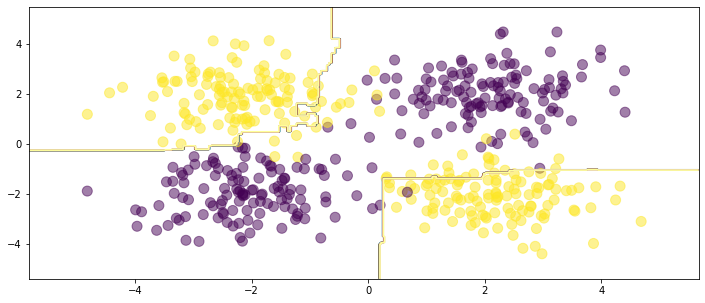

In [38]:
model = BaggedTreeClassifier(200)
model.fit(X, Y)

print("score for bagged model:", model.score(X, Y))

# plot data with boundary
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(plt, X, model)
plt.show()

Again the bagged model produced smoother decision boundary than single decision tree.

## <font color='darkblue'>Stacking</font>
([link](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6240254#questions))
* Stacking: another way of combining models
* We've assumed so far that each model's influence must be equal.
* How about weighting them?
* Stacking is not the only way to find these weights, we'll explore another later in the course.
* As usual, we want to minimize MSE:
![Minimize MSE](images/S3_17-1.PNG)
<br/>

* Look closely, this is just linear regression:
![Minimize MSE](images/S3_17-2.PNG)
<br/>
* But we don't know the population distribution
* What if we just substitute the training data?
* Recall from linear regression: larger dimensionality -> better $R^{2}$
* If $f_{m}(x)$ = linear regression with `m` inputs, then $f_{M}(x)$ is always the best.
* So $W_{M}=1, W_{1}=...=W_{M-1}=0$
* Instead, train on all points except $(x_{i}, y_{i})$, calculate error over every ith pair
![Minimize MSE](images/S3_17-3.PNG)
<br/>
* Add constraints to `w`:
![Minimize MSE](images/S3_17-4.PNG)
<br/>
* This is known as a <b>[quadratic programming problem](https://en.wikipedia.org/wiki/Quadratic_programming)</b>. Shows up with SVMs too. You can take a whole class on QP and we won't go further here. There should be library to solve this problem for you.

### <font color='darkgreen'>Leave-One-Out Cross Validation</font>
* You may recognize this as similar to leave-one-out cross-validation
* Suppose we did LOO-CV, we create M different models (M different settings of hyperparameters)
* We would usually choose the best model (equivalent to $w_{m}*=1$)
![Minimize MSE](images/S3_17-5.PNG)
<br/>